# Training

## Risoluzione dipendenze e caricamento dataset

In [1]:
# Installa tutte le dipendenze.
!pip install -r requirements.txt

In [2]:
# Importa tutte le librerie necessarie.
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

In [3]:
# Carica i due dataset di training e di test.
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

## Analisi preliminare e pulizia del dataset

In [4]:
# Vediamo quale è la dimensione dei due set.
print('Dimensione train set: ' + str(train.shape))
print('Dimensione test  set: ' + str(test.shape))

Dimensione train set: (6400, 14)
Dimensione test  set: (1600, 14)


In [5]:
# Mi faccio un'idea di come è fatto il training set, visualizzandone le prime 10 righe.
train.head(10)

,Exited,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,0,2604,15583049,Wallace,643,Germany,Female,34,7,160426.07,1,0,1,188533.11
1,0,5125,15612140,Milano,721,Spain,Female,46,7,137933.39,1,1,1,67976.57
2,0,6789,15800268,Costa,825,Germany,Male,37,6,118050.79,1,0,1,52301.15
3,1,9338,15797751,Pai,466,Germany,Female,47,5,102085.72,1,1,1,183536.24
4,0,7480,15671987,Meagher,567,Spain,Male,35,8,153137.74,1,1,0,88659.07
5,0,9387,15672027,McIntyre,717,Germany,Female,33,10,102185.42,2,1,0,23231.93
6,0,7603,15791769,Gardener,691,France,Female,29,9,116536.43,1,1,0,51987.99
7,0,877,15581229,Gregory,502,Germany,Female,32,1,173340.83,1,0,1,122763.95
8,0,5878,15758510,Frolova,474,France,Male,26,6,0.00,2,0,0,152491.22
9,0,8579,15707011,Morrison,495,France,Male,47,10,137682.68,1,1,0,71071.47


0    5082
1    1318
Name: Exited, dtype: int64


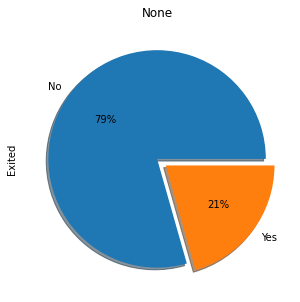

In [6]:
# Per prima cosa, vediamo come si ripartiscono i clienti nelle due categorie.
def plot_target_distribution(target):
    exited_value_counts = target.value_counts()
    print(exited_value_counts)
    plot = exited_value_counts.plot.pie(
        figsize = (5, 5),
        explode = (0, 0.1),
        shadow = True,
        autopct = '%1.0f%%',
        labels = ['No', 'Yes'],
        title = 'None'
    )

plot_target_distribution(train['Exited'])

Sembra che i clienti che vogliono cambiare banca siano molti meno di quelli che non hanno intenzione di farlo. Il dataset è quindi sbilanciato.

In [7]:
# Mostro l'elenco di tutte le colonne del dataset, insieme al loro tipo di dato.
train.dtypes

Exited               int64
RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
dtype: object

Non sembrerebbero esserci grossi problemi per quanto riguarda i tipi di dato delle colonne.   
Da notare però che ci sono delle feature categoriche (`Exited`, `HasCrCard`, `IsActiveMember`) che sono già codificate come interi. Questo va senz'altro bene per la fase di addestramento (gli algoritmi di ML hanno bisogno di feature numeriche), ma in questa fase di analisi, per evitare confusione, preferirei convertirle in un valore di tipo `object`.
    
Definisco quindi qui sotto una funzione per effettuare questa prima modifica ai dati.

In [8]:
def fixDataTypes(data):
    
    # Crea una copia dei dati per non corrompere quelli originali.
    data = data.copy()
    
    # Converti le colonne Exited, HasCrCard, IsActiveMember in categoriche.
    data['Exited'] = data['Exited'].map({1: 'Yes', 0: 'No'})
    data['HasCrCard'] = data['HasCrCard'].map({1: 'Yes', 0: 'No'})
    data['IsActiveMember'] = data['IsActiveMember'].map({1: 'Yes', 0: 'No'})
    
    # Restituisci i dati trasformati.
    return data

# Applica la trasformazione sia al train che al test set.
train = fixDataTypes(train)
test  = fixDataTypes(test)

# Mostro il nuovo train set.
train.head(10)

,Exited,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,No,2604,15583049,Wallace,643,Germany,Female,34,7,160426.07,1,No,Yes,188533.11
1,No,5125,15612140,Milano,721,Spain,Female,46,7,137933.39,1,Yes,Yes,67976.57
2,No,6789,15800268,Costa,825,Germany,Male,37,6,118050.79,1,No,Yes,52301.15
3,Yes,9338,15797751,Pai,466,Germany,Female,47,5,102085.72,1,Yes,Yes,183536.24
4,No,7480,15671987,Meagher,567,Spain,Male,35,8,153137.74,1,Yes,No,88659.07
5,No,9387,15672027,McIntyre,717,Germany,Female,33,10,102185.42,2,Yes,No,23231.93
6,No,7603,15791769,Gardener,691,France,Female,29,9,116536.43,1,Yes,No,51987.99
7,No,877,15581229,Gregory,502,Germany,Female,32,1,173340.83,1,No,Yes,122763.95
8,No,5878,15758510,Frolova,474,France,Male,26,6,0.00,2,No,No,152491.22
9,No,8579,15707011,Morrison,495,France,Male,47,10,137682.68,1,Yes,No,71071.47


In [9]:
# Mostro una descrizione riassuntiva di tutte le feature nel train set.
cat_desc = train.describe(include = ['object']).T
num_desc = train.describe(exclude = ['object']).T

print('Feature Numeriche: ')
display(num_desc)
print('\nFeature Categoriche: ')
display(cat_desc)

Feature Numeriche: 


,count,mean,std,min,25%,50%,75%,max
RowNumber,6400.0,5.003472e+03,2892.324766,2.00,2.501750e+03,4.994000e+03,7.485000e+03,10000.00
CustomerId,6400.0,1.569045e+07,71817.852956,15565701.00,1.562795e+07,1.569054e+07,1.575318e+07,15815660.00
CreditScore,6400.0,6.515442e+02,96.615192,350.00,5.850000e+02,6.530000e+02,7.190000e+02,850.00
Age,6400.0,3.894922e+01,10.488688,18.00,3.200000e+01,3.700000e+01,4.400000e+01,92.00
Tenure,6400.0,5.018906e+00,2.874809,0.00,3.000000e+00,5.000000e+00,7.000000e+00,10.00
Balance,6400.0,7.637832e+04,62502.309420,0.00,0.000000e+00,9.641052e+04,1.278199e+05,250898.09
NumOfProducts,6400.0,1.528437e+00,0.580027,1.00,1.000000e+00,1.000000e+00,2.000000e+00,4.00
EstimatedSalary,6400.0,9.998370e+04,57856.440073,90.07,5.026306e+04,9.980959e+04,1.496996e+05,199970.74



Feature Categoriche: 


,count,unique,top,freq
Exited,6400,2,No,5082
Surname,6400,2325,Martin,21
Geography,6400,3,France,3167
Gender,6400,2,Male,3491
HasCrCard,6400,2,Yes,4503
IsActiveMember,6400,2,Yes,3283


Vorrei riservare adesso particolare attenzione alle colonne `RowNumber` e `CustomerId`: intuitivamente, sembrano essere rispettivamente una sorta di indice di riga nel database dei clienti e un identificatore univoco del cliente.   
Verifico quindi adesso se tali feature hanno effettivamente un valore diverso per ogni cliente.

In [10]:
train[['RowNumber', 'CustomerId']].nunique()

RowNumber     6400
CustomerId    6400
dtype: int64

Come immaginavo, abbiamo un valore diverso di entrambe le feature per ogni cliente.
Queste due feature non sono chiaramente discriminanti nel determinare se un cliente ha o meno intenzione di lasciare la banca, e quindi vanno eliminate.

In [11]:
def drop_unique_features(data):
    return data.drop(['RowNumber', 'CustomerId'], axis = 1)

# Eliminiamo l'id utente sia dal train che dal test set.
train = drop_unique_features(train)
test  = drop_unique_features(test)

A questo punto, vorrei riservare particolare attenzione anche alla feature `Surname`, ovvero al cognome del cliente.
Tale feature non è esattamente univoca per ogni cliente, ma la quantità di valori univoci è veramente alta (2325). Questo potrebbe causare dei problemi in futuro nel caso in cui dovesse essere necessario codificare le feature categoriche seguendo l'approccio "One Hot".   
In ogni caso, questa feature mi sembra intuitivamente molto poco utile ai nostri fini: decido quindi di semplificare ulteriormente il dataset eliminandola.

In [12]:
train = train.drop('Surname', axis = 1)
test  = test.drop('Surname', axis = 1)

A questo punto può essere utile visualizzare l'elenco di tutti i valori presenti per ogni categoria.

In [13]:
# Funzione che calcola l'insieme dei valori presenti per ogni feature categorica.
def get_cat_unique_values(data):
    return {
        col: set(data[col].unique())
        for col in data.select_dtypes(['object']).columns
    }

get_cat_unique_values(train)

{'Exited': {'No', 'Yes'},
 'Geography': {'France', 'Germany', 'Spain'},
 'Gender': {'Female', 'Male'},
 'HasCrCard': {'No', 'Yes'},
 'IsActiveMember': {'No', 'Yes'}}

Non sembrano esserci anomalie in questi valori.   
Preferisco però convertire tutte queste feature categoriche in un tipo apposito fornito dalla libreria Pandas.

In [14]:
cat_columns = train.select_dtypes(['object']).columns
train[cat_columns] = train[cat_columns].astype('category')
test[cat_columns]  = test[cat_columns].astype('category')

Occupiamoci ora di eventuali valori mancanti nelle colonne.
Dalla breve descrizione visualizzata sopra, almeno nelle colonne categoriche sembra che non ci siano valori nulli.
Verifichiamolo con maggiore accuratezza, in modo da esserne sicuri.

In [15]:
# Funzione che restituisce l'insieme delle colonne contenenti valori mancanti.
# La funzione restituisce un dizionario le cui chiavi sono i nomi delle colonne con valori mancanti e i valori
# il numero di occorrenze nulle.
def get_cols_with_missing(train, test):
    
    return {
        col: (train[col].isnull().sum() + test[col].isnull().sum())
        for col in train.columns
        if train[col].isnull().any() or test[col].isnull().any()
    }

get_cols_with_missing(train, test)

{}

Fortunatamente, nel dataset non c'è nessun valore nullo!

## Analisi e trasformazione del dataset
Per prima cosa, definisco alcune funzioni per graficare le relazioni tra le varie feature e la variabile target.

In [16]:
# Funzione per calcolare il numero di righe e colonne ottimale per una griglia di grafici, in base al numero di
# grafici da visualizzare e al massimo numero di grafici per riga ammesso.
def plot_grid_rows_cols(plots_num, max_plots_per_row):
    if (plots_num <= max_plots_per_row):
        ncols = plots_num
    else:
        ncols = max_plots_per_row
    nrows = math.ceil(plots_num / max_plots_per_row)
    
    return (nrows, ncols)


# Funzione che costruisce una griglia di grafici che mettono in relazione un certo insieme di feature
# (considerate singolarmente) con la variabile target.
def plot_grid(
    features,
    target,
    plot_func = sns.histplot,
    plot_args = {},
    data = None,
    max_plots_per_row = 3,
    figsize = (10, 6)
):
    
    # Se alla funzione è stato passato un dataframe, estrai feature e target da lì.
    if data is not None:
        features = data[features]
        target = data[target]
    
    # Calcolo il numero di righe e colonne della griglia di grafici, in base al numero delle feature.
    features_num = len(features.columns)
    nrows, ncols = plot_grid_rows_cols(features_num, max_plots_per_row)
    
    # Costruisco la griglia di grafici.
    fig, axs = plt.subplots(ncols = ncols, nrows = nrows, squeeze = False, figsize = figsize)
    
    # Mostra i grafici per tutte le varie feature.
    for i in range(features_num):
        plot_func(
            x = features.iloc[:, i],
            hue = target,
            ax = axs[i // max_plots_per_row][i % max_plots_per_row],
            **plot_args
        )
    
    # Rimuovi grafici inutili e vuoti.
    for j in range(i + 1, ncols * nrows):
        fig.delaxes(axs[j // max_plots_per_row][j % max_plots_per_row])
        
    # Perfeziona la spaziatura tra i vari grafici.
    plt.subplots_adjust(wspace = 0.2, hspace = 0.5)
    plt.show()

Per risolvere questo problema di classificazione, utilizzerò un `RandomForestClassifier`, ovvero una "foresta" di alberi di decisione. Questo modello costruisce una moltitudine di alberi di decisione: la predizione dell'intera foresta corrisponde alla media delle predizioni dei singoli alberi che la compongono. Questo approccio garantisce prestazioni solitamente migliori che non addestrando un singolo albero di decisione.

Per analizzare i progressi fatti durante la trasformazione dei dati, utilizzerò una funzione di utilità `score_model` per valutare le performance del modello.
Poiché non abbiamo moltissimi esempi nel nostro dataset (ne abbiamo qualche migliaio), in fase di valutazione del modello utilizzerò la Cross Validation e restituirò come metrica di valutazione la media delle accuracy calcolate per ognuno dei "fold".

In [17]:
# Codifica tutte le feature categoriche e la variabile target, trasformandole in numeriche.
# Utilizzerò la codifica Label per le categorie binarie e la codifica One-Hot per le altre.
def encode(X, y):
    
    # Lista delle colonne categoriche.
    cat_columns = X.select_dtypes(['category']).columns
    
    # Lista delle colonne binarie.
    binary_columns = [
        col
        for col in cat_columns
        if len(X[col].cat.categories) <= 2
    ]
    
    # Lista delle colonne NON binarie.
    multi_value_columns = cat_columns.difference(binary_columns)
    
    # Converti le colonne NON binarie in numeriche, seguendo l'approccio One-Hot Encoding.
    X = pd.get_dummies(X, columns = multi_value_columns)
    
    # Converti le colonne binarie in numeriche, seguendo l'approccio Label Encoding.
    for col in binary_columns:
        X[col] = X[col].cat.codes
    
    return (X, y.cat.codes)


# Funzione che restituisce un "preprocessore" dei dati, che viene utilizzato per effettuare determinate
# trasformazioni sul dataset (e.g. scalatura dei dati).
def make_preprocessor(numeric_columns):
    return ColumnTransformer(
        remainder = 'passthrough',
        transformers = [
            ('scaler', StandardScaler(), numeric_columns)
        ]
    )


# Funzione che restituisce un classificatore di base, da utilizzare per analizzare i risultati delle
# trasformazioni sul dataset tramite Cross Validation
def make_classifier():
    return RandomForestClassifier(n_estimators = 50, random_state = 13)
    

# Funzione che restituisce una pipeline di base, da utilizzare per analizzare i risultati delle
# trasformazioni sul dataset tramite Cross Validation.
def base_pipeline(numeric_columns):
    return Pipeline(
        steps = [
            ('preprocessor', make_preprocessor(numeric_columns)),
            ('classifier', make_classifier())
        ]
    )
    

# Funzione per valutare il modello base tramite Cross Validation.
def score_model(X, y, model = None, mustEncode = True):
    
    # Se non è stato fornito alcun modello, ne costruisco uno di base.
    if model == None:
        model = base_pipeline(X.select_dtypes(exclude = ['category']).columns)
    
    # Codifico le feature categoriche e il target (se necessario).
    if (mustEncode):
        X, y = encode(X, y)
    
    # Calcolo le accuracy per tutti i 5 fold.
    scores = cross_val_score(
        model, X, y, cv = 5, scoring = 'accuracy'
    )
    
    # Restituisco la media di tutte le accuracy calcolate.
    return scores.mean()

A questo punto, calcolo l'accuracy attuale per il dataset corrente e il modello di base. In questo modo, potrò verificare se le future azioni di trasformazione del dataset porteranno o meno dei benefici o dei peggioramenti.

In [18]:
# Suddivido train e test set in features (X) e target (y).
X_train = train.drop('Exited', axis = 1)
X_test  = test.drop('Exited', axis = 1)
y_train = train['Exited']
y_test  = test['Exited']

# Valuto il modello corrente.
score_model(X_train, y_train)

0.85546875

L'accuracy iniziale del nostro modello non è affatto male.   
Nella sezione successiva proverò a modificare il dataset per cercare di migliorare le prestazioni del modello e di snellire il nostro dataset (con il beneficio di ridurre anche il rischio di eventuale overfitting) senza degradarle eccessivamente, con l'obiettivo di trovare il minimo insieme di informazione necessario per spiegare il fenomeno che abbiamo in esame (clienti che abbandonano o meno la propria banca).

## Feature Engineering
Proverò adesso ad analizzare ulteriormente i dati e ad applicare alcune tecniche di feature engineering.   
La prima cosa che voglio fare è calcolare i coefficienti di correlazione tra tutte le feature numeriche del dataset.

<AxesSubplot:>

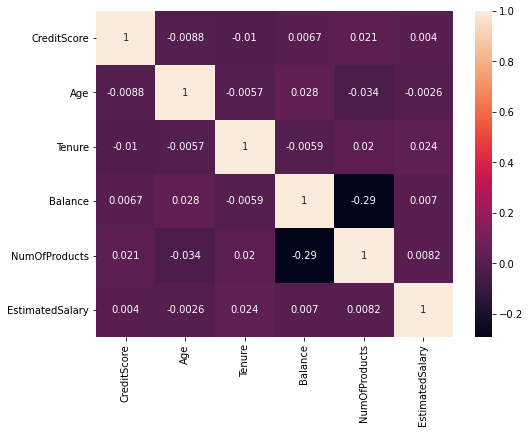

In [19]:
plt.figure(figsize = (8, 6))
sns.heatmap(X_train.corr(), annot = True)

Possiamo osservare come le feature siano tutte piuttosto indipendenti l'una dall'altra.
L'analisi della matrice di correlazione non ci suggerisce quindi di eliminare alcuna feature.

Proseguiamo ora con una prima analisi sull'utilità di tutte le feature, considerate singolarmente.
Per avere una misura dell'utilità di ogni feature ne calcolerò il valore di Mutua Informazione (in seguito abbreviato con MI) con la variabile target.   
La MI è un valore che misura la dipendenza tra due variabili in termini di incertezza: più tale valore è alto, maggiore è l'informazione su una delle due variabili che possiamo ricavare conoscendo il valore dell'altra.   
La MI ha il vantaggio di captare sia relazioni lineari che non lineari e di essere adeguata sia per variabili numeriche che categoriche.
Definisco quindi qui sotto alcune funzioni di utilità per il calcolo dei valori di MI tra la variabile target e tutte le feature, nonché per la visualizzazione di tali valori.   
Il credito per buona parte di questo codice va a Ryan Holbrook, autore del micro-corso "Feature Engineering" su Kaggle.

In [20]:
# Calcola i valori di MI tra tutte le feature X e il target y.
def compute_mi_scores(X, y):
    
    # Codifica le feature categoriche e la variabile target, convertendole in numeriche.
    X = X.copy()
    for col in X.select_dtypes(['category']):
        X[col], _ = X[col].factorize()
    y, _ = y.factorize()
    
    # Elenco delle feature "discrete": tutte quelle che ora sono di tipo numerico intero.
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    
    # Calcola i valori di MI.
    mi_scores = mutual_info_classif(X, y, discrete_features = discrete_features, random_state = 0)
    mi_scores = pd.Series(mi_scores, name = "MI Scores", index = X.columns)
    mi_scores = mi_scores.sort_values(ascending = False)
    return mi_scores


# Grafica i valori di MI.
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending = True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.figure(figsize = (10, 6))
    plt.barh(width, scores)
    plt.yticks(width, ticks, size = 12)
    plt.title("Mutual Information Scores")

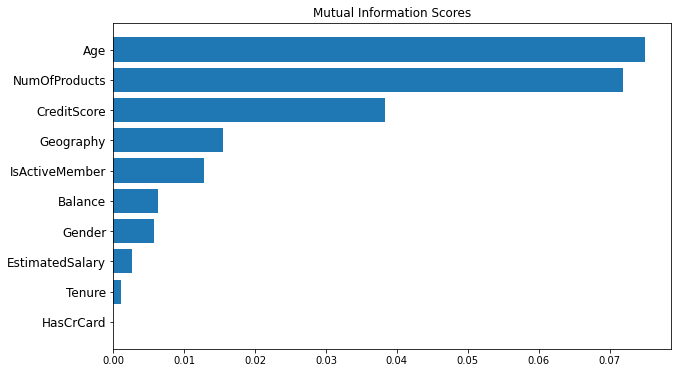

In [21]:
# Calcola e grafica i valori di MI.
mi_scores = compute_mi_scores(X_train, y_train)
plot_mi_scores(mi_scores)

Dall'analisi, risulta esserci una feature in particolare che non ha particamente quasi alcuna influenza sull'output: `HasCrCard`.   
Grafichiamone la relazione con la variabile target.

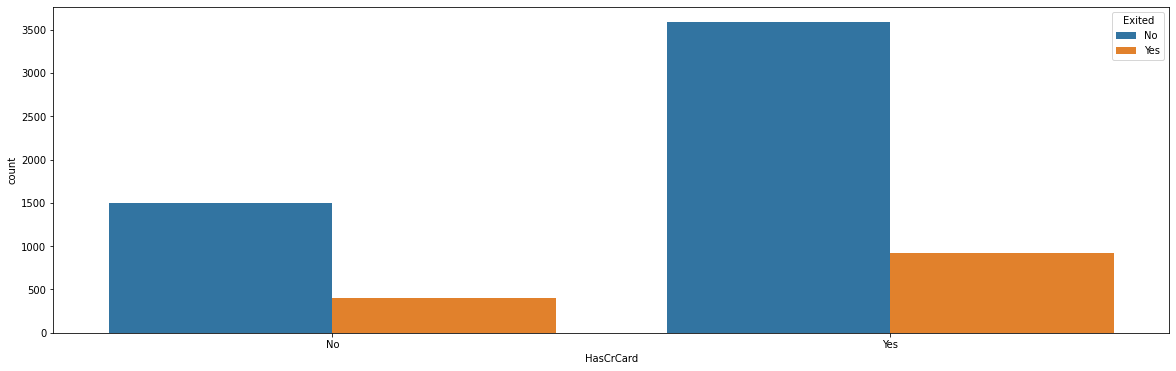

In [22]:
plot_grid(
    features = X_train[['HasCrCard']],
    target = y_train,
    plot_func = sns.countplot,
    max_plots_per_row = 3,
    figsize = (20, 6)
)

Effettivamente, osservando il grafico, non sembra che questa feature influisca molto sul valore della variabile `Exited` (i rapporti di altezza tra barre blu e arancioni sono grosso modo gli stessi per entrambi i valori della feature).   
Decido quindi di semplificare il dataset eliminandola.

In [23]:
X_train.drop(['HasCrCard'], axis = 1, inplace = True)
X_test.drop(['HasCrCard'], axis = 1, inplace = True)

Valutiamo ora le prestazioni del nuovo modello.

In [24]:
score_model(X_train, y_train)

0.8546875

L'accuracy è calata di un valore insignificante!

A questo punto, proseguo con la visualizzazione della relazione tra la variabile target e le prime due feature che hanno ottenuto il punteggio di MI più alto.

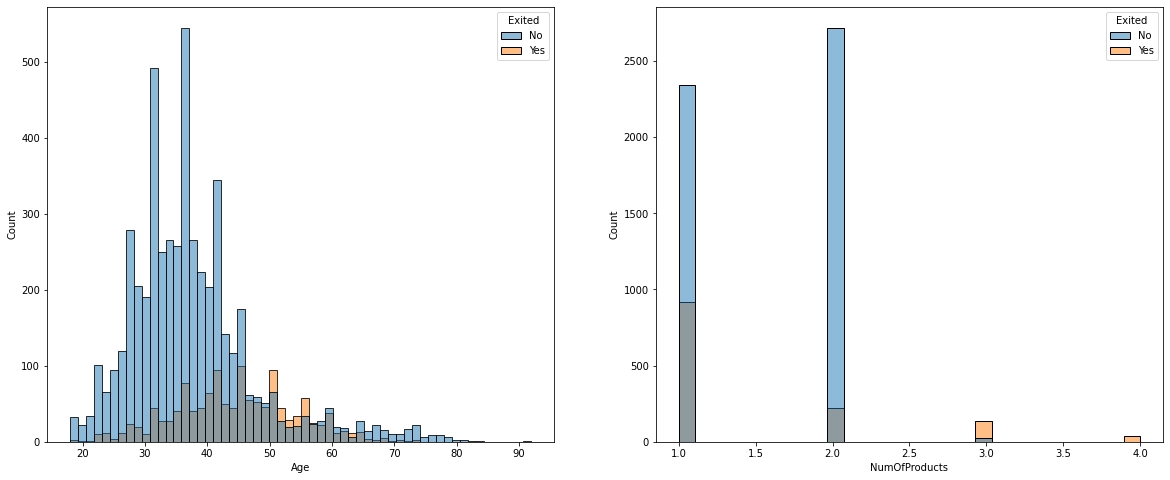

In [25]:
plot_grid(
    features = X_train[['Age', 'NumOfProducts']],
    target = y_train,
    plot_func = sns.histplot,
    max_plots_per_row = 2,
    figsize = (20, 8)
)

Questa volta possiamo osservare come invece queste due feature abbiano una maggiore influenza sulla variabile target.   
Possiamo osservare in particolare che i clienti più propensi a cambiare banca sono concentrati più che altro nella fascia d'età 45-65 (e soprattutto 50-60). I clienti più giovani sono invece quelli meno propensi a cambiare.   
Anche il numero di prodotti finanziari utilizzati fa la differenza: i clienti che ne usano 2 sono quelli più fedeli alla propria banca, quelli che ne usano 1 solo tendono a cambiare banca un po' di più e quelli che ne usano 3 o 4 sono molto più propensi a cambiare.

Grafichiamo ora la relazione tra la feature `CreditScore` (terza classificata nella classifica dei punteggi di MI) e la variabile target.

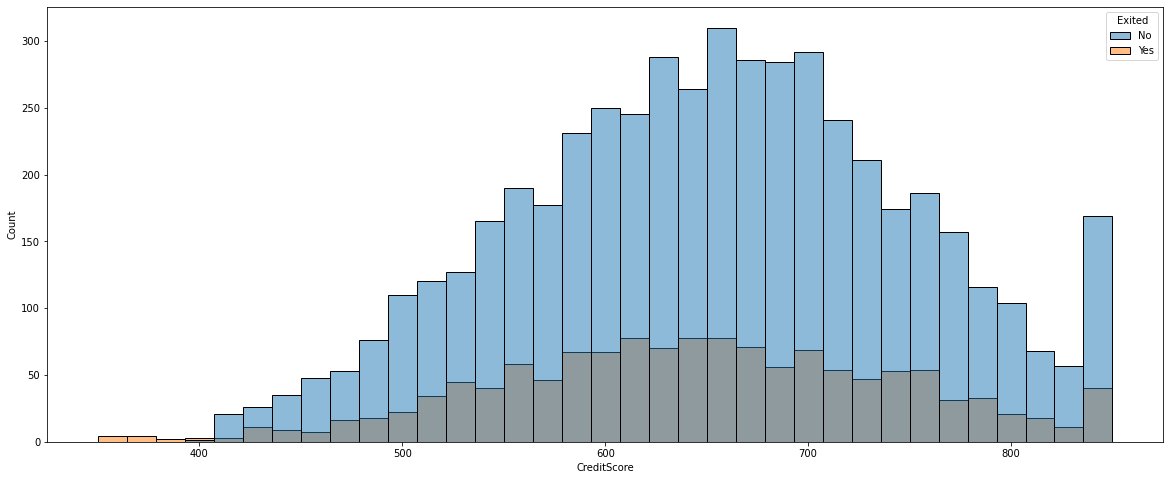

In [26]:
plot_grid(
    features = X_train[['CreditScore']],
    target = y_train,
    plot_func = sns.histplot,
    max_plots_per_row = 2,
    figsize = (20, 8)
)

Nonostante il punteggio di MI ottenuto, osservando il grafico non sembra che questa feature sia poi così tanto significativa nella distinzione tra clienti che lasciano la banca e clienti che rimangono.   
L'unica parte interessante del grafico è quella più a sinistra, in cui si hanno più clienti che cambiano banca che non il contrario. Tutto il resto del grafico sembra però fornire ben poche informazioni utili: gli istogrammi dei clienti che rimangono fedeli alla propria banca e di quelli che invece la abbandonano seguono grosso modo un andamento piuttosto simile.

Decido quindi di provare ad eliminare anche questa feature.

In [27]:
X_train.drop('CreditScore', axis = 1, inplace = True)
X_test.drop('CreditScore', axis = 1, inplace = True)

Valutiamo ora nuovamente le prestazioni del modello.

In [28]:
score_model(X_train, y_train)

0.85453125

Le prestazioni non sono sostanzialmente cambiate, il che ci da' una conferma che anche quest'altra feature eliminata non era poi così utile ai fini del funzionamento del nostro modello.

Analizziamo ora la relazione tra la variabile target e la feature categorica che ha ottenuto il punteggio di MI più alto: `Geography`.

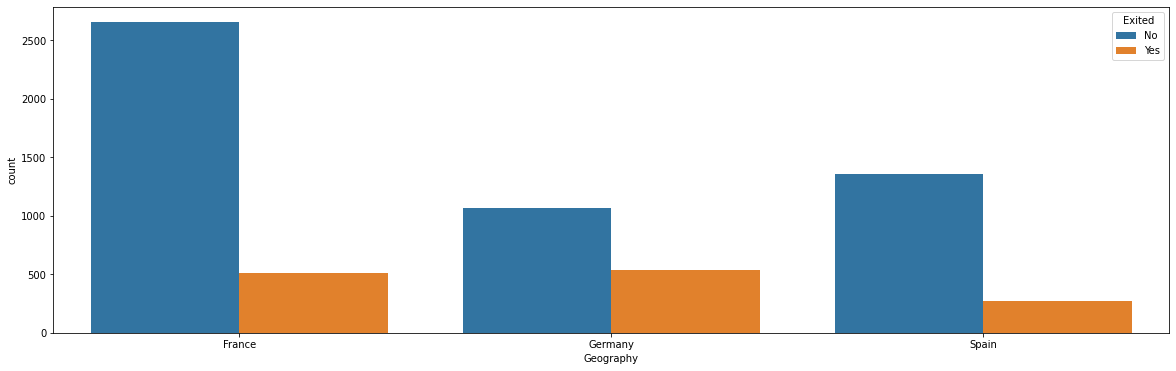

In [29]:
plot_grid(
    features = X_train[['Geography']],
    target = y_train,
    plot_func = sns.countplot,
    max_plots_per_row = 2,
    figsize = (20, 6)
)

Possiamo per prima cosa notare come la stragrande maggioranza dei clienti campionati siano francesi.   
Si osserva facilmente che i clienti tedeschi sono molto più propensi a cambiare banca rispetto agli altri.

Analizziamo ora come le altre due feature categoriche rimaste, che hanno valori di MI più bassi, si relazionano con la variabile `Exited`.

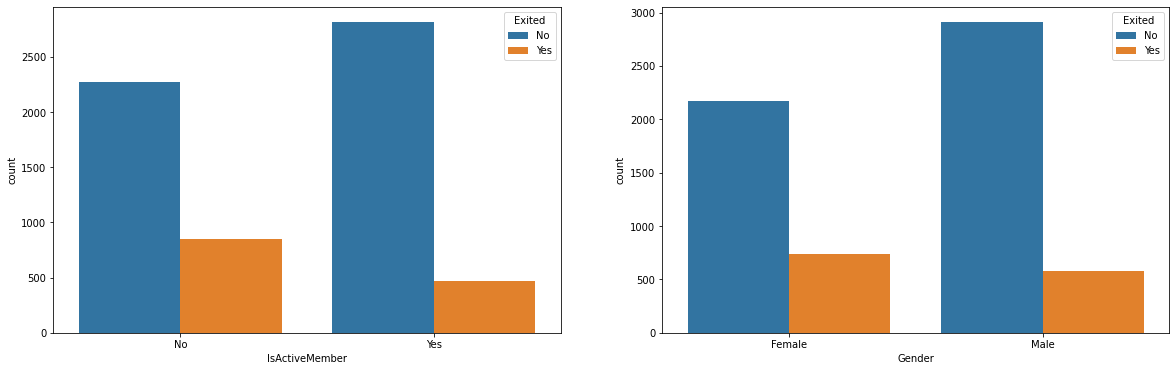

In [30]:
plot_grid(
    features = X_train[['IsActiveMember', 'Gender']],
    target = y_train,
    plot_func = sns.countplot,
    max_plots_per_row = 2,
    figsize = (20, 6)
)

Osserviamo come i clienti che NON hanno un conto attivo sono quelli più propensi a cambiare banca (forse il fatto che non si abbia un conto attivo facilita il cambio di banca?), così come le donne (anche se in questo caso la differenza è meno evidente).

Analizziamo ora le feature numeriche `Balance` ed `EstimatedSalary`.

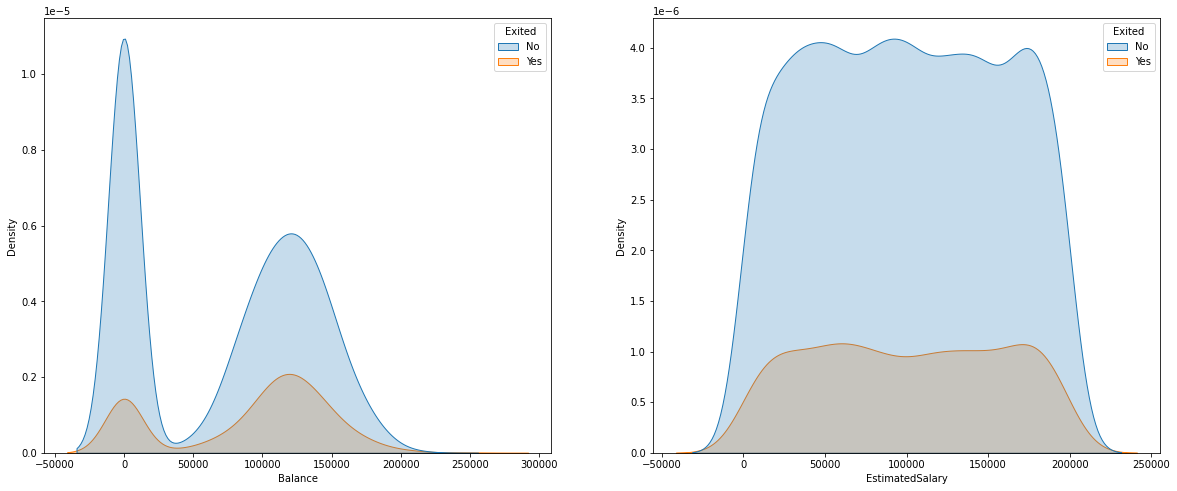

In [31]:
plot_grid(
    features = X_train[['Balance', 'EstimatedSalary']],
    target = y_train,
    plot_func = sns.kdeplot,
    plot_args = {'shade': True},
    max_plots_per_row = 2,
    figsize = (20, 8)
)

Possiamo osservare come più l'ammontare del conto in banca di un cliente è vicino allo 0, più questo tende ad essere fedele alla propria banca. La curva della distribuzione della feature `Balance` ha due picchi: uno in corrispondenza dello 0 e uno in corrispondenza di un valore intorno ai 120000€: la differenza tra clienti che lasciano e clienti che rimangono è molto più marcata per il primo picco.
Più ci si avvicina ai punti di picco, più la differenza tra le due curve blue e arancione tende a crescere,  mentre tende a diminuire mano a mano che si affievoliscono.     
Osserviamo come invece la feature `EstimatedSalary` non sembri avere una relazione così forte con la variabile target, il che non dovrebbe sorprenderci visto che non aveva ottenuto un alto valore di MI.

A questo punto manca solo la feature `Tenure`, che a giudicare dal punteggio di MI sembra non avere un grosso impatto sulla scelta del cliente.
Vediamo come tale feature si relaziona con la variabile target.

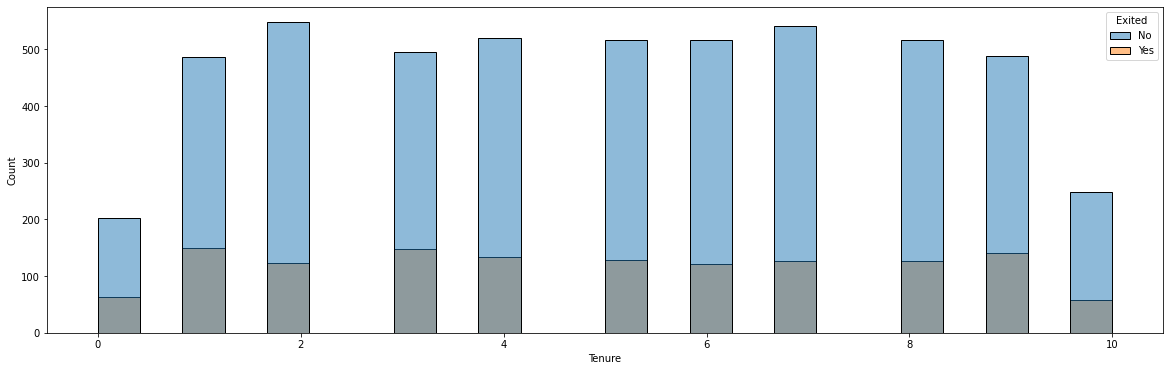

In [32]:
plot_grid(
    features = X_train[['Tenure']],
    target = y_train,
    plot_func = sns.histplot,
    max_plots_per_row = 3,
    figsize = (20, 6)
)

Osservando questo grafico, sembra che dalla conoscenza della variabile `Tenure` non si riesca a ricavare molta informazione sulla variabile `Exited`.   
Provo quindi ad eliminare anche questa feature.

In [33]:
X_train.drop(['Tenure'], axis = 1, inplace = True)
X_test.drop(['Tenure'], axis = 1, inplace = True)

Valutiamo nuovamente il nostro modello.

In [34]:
score_model(X_train, y_train)

0.8456250000000001

Le prestazioni stavolta sono calate un pochino di più, anche se comunque meno di 1 punto percentuale.   
Non lo considererei un calo così significativo, quindi sembra effettivamente che il valore della feature `Tenure` non sia importante per capire se un cliente ha lasciato o meno la sua banca.

A questo punto, può essere utile provare a creare nuove feature che possano essere più informative di quelle che abbiamo ora.   
Una tipologia di feature "artificiali" che in generale possono aiutare i modelli a migliorare le loro performance predittive sono i rapporti tra altre feature.   
Come osservato in precedenza, la feature `EstimatedSalary` non è molto informativa rispetto a quelle che hanno ottenuto valori di MI più alti. Mi chiedo se un rapporto tra la feature `Balance` e la feature `EstimatedSalary` non possa essere più utile della feature `EstimatedSalary` stessa: provo a creare una nuova feature `BalanceSalaryRatio`, che consiste nel rapporto tra l'ammontare del conto in banca di un utente e le sue entrate stimate, e ad eliminare la "vecchia" feature `EstimatedSalary`.

In [35]:
def addBalanceSalaryRatio(data):
    data = data.copy()
    data['BalanceSalaryRatio'] = data['Balance'] / data['EstimatedSalary']
    data.drop(['EstimatedSalary'], axis = 1, inplace = True)
    return data

X_train = addBalanceSalaryRatio(X_train)
X_test  = addBalanceSalaryRatio(X_test)

Vediamo come si presenta questa nuova feature, osservando le prime 3 righe del dataset.

In [36]:
X_train.head(3)

,Geography,Gender,Age,Balance,NumOfProducts,IsActiveMember,BalanceSalaryRatio
0,Germany,Female,34,160426.07,1,Yes,0.850917
1,Spain,Female,46,137933.39,1,Yes,2.029131
2,Germany,Male,37,118050.79,1,Yes,2.257136


Grafichiamo ora la distribuzione della nuova feature.

<AxesSubplot:xlabel='BalanceSalaryRatio', ylabel='Density'>

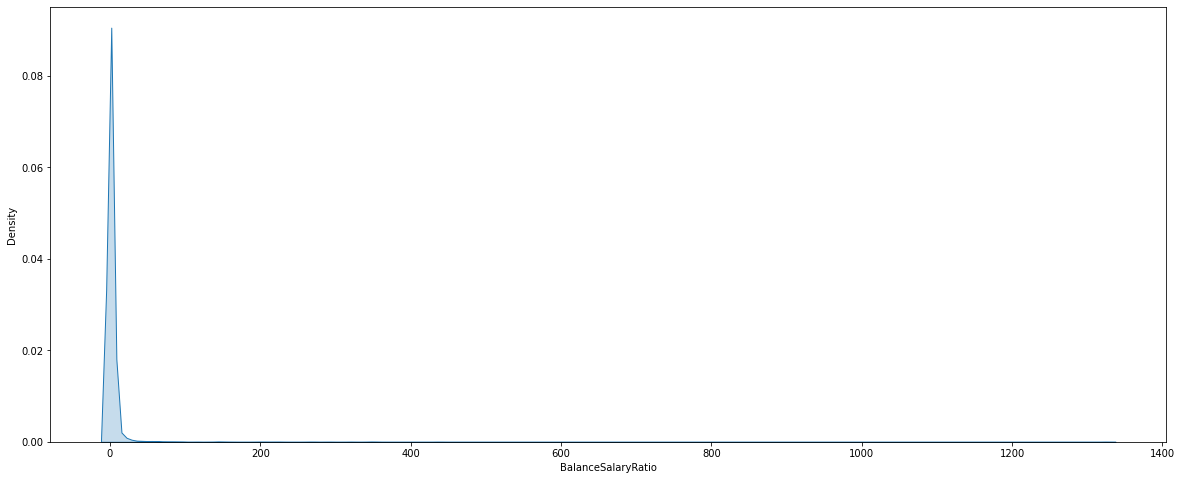

In [37]:
plt.figure(figsize = (20, 8))
sns.kdeplot(X_train['BalanceSalaryRatio'], shade = True)

Come possiamo vedere, tale distribuzione è troppo "schiacciata".   
Decido quindi di applicare alla feature una trasformazione logaritmica, nel tentativo di normalizzarne la distribuzione.

In [38]:
X_train['BalanceSalaryRatio'] = X_train['BalanceSalaryRatio'].apply(np.log1p)

Grafichiamo ora la relazione tra la nuova feature e la variabile target.

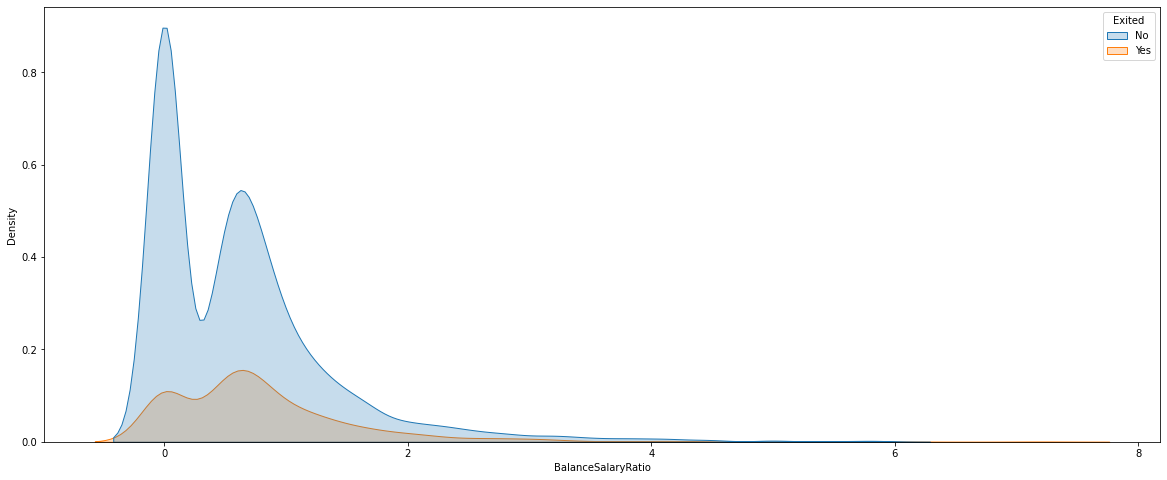

In [39]:
plot_grid(
    features = X_train[['BalanceSalaryRatio']],
    target = y_train,
    plot_func = sns.kdeplot,
    plot_args = {'shade': True},
    max_plots_per_row = 3,
    figsize = (20, 8)
)

Come per la vecchia feature `EstimatedSalary`, anche stavolta abbiamo due picchi principali presso i quali i clienti che vogliono rimanere fedeli alla propria banca tendono ad essere di più di quelli che vogliono lasciarla. Nelle zone in cui le curve si appiattiscono questa differenza diventa invece sempre meno marcata, tanto che sia nella parte estrema sinistra che in quella estrema destra del grafico risultano essere più coloro che abbandonano la propria banca che non gli altri.

Valutiamo ora il nuovo modello.

In [40]:
score_model(X_train, y_train)

0.8496875000000002

Sembra che le prestazioni siano leggermente migliorate di circa mezzo punto percentuale: decisamente nulla di eccezionale, ma la nuova feature mi sembra comunque essere un pochino più informativa della precedente.

## Oversampling

Come già visto all'inizio del notebook, il nostro dataset è molto sbilanciato: ci sono molti più esempi negativi che positivi.   
Questo ha chiaramente un impatto negativo sulle performance del mdello, che potrebbe non essere in grado di individuare i giusti pattern nei dati. In particolare, il rischio è che il modello non impari a classificare correttamente gli esempi positivi.

Per risolvere questo problema, utilizzerò la tecnica *SMOTE* per sovradimensionare il nostro train set, in modo che il numero di esempi negativi e positivi sia uguale. Questo approccio costruisce artificialmente dei nuovi esempi positivi a partire da quelli già esistenti. A grandi linee, questa tecnica seleziona di volta in volta coppie di punti positivi (cioè della classe in minoranza, in generale) e crea un nuovo esempio positivo "artificiale" come il punto medio del segmento che li congiunge nello spazio delle feature.

Poiché questo algoritmo lavora con sole feature numeriche, per prima cosa codificherò il train set, transformandone le colonne categoriche in numeriche.

In [41]:
X_train_enc, y_train_enc = encode(X_train, y_train)

In [42]:
# Oggetto che implementa la tecnica SMOTE per bilanciare gli esempi positivi e negativi nel dataset.
smote = SMOTE(sampling_strategy = 'minority', random_state = 13)
X_train_enc, y_train_enc = smote.fit_resample(X_train_enc, y_train_enc)

# Reimposto il nome della Series per la variabile target, in quanto la SMOTE l'ha cancellato.
y_train_enc.name = 'Exited'

Vediamo come si ripartiscono adesso i valori nelle due classi target.

0    5082
1    5082
Name: Exited, dtype: int64


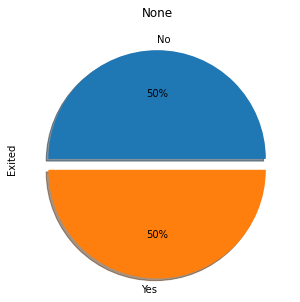

In [43]:
plot_target_distribution(y_train_enc)

Come ci aspettavamo, il dataset è ora bilanciato!

Calcoliamoci ora lo score per il nuovo dataset.

In [44]:
score_model(X_train_enc, y_train_enc, mustEncode = False)

0.8668868686360099

Come possiamo vedere, lo score è aumentato di oltre 1 punto e mezzo percentuale: non è molto, ma lo *SMOTE* sembra comunque essersi rivelato utile.

## Addestramento e Valutazione
Arrivati a questo punto, addestrerò il modello sul train set corrente e lo valuterò sul test set.

In [45]:
# Lista delle colonne numeriche.
num_cols = list(X_train.select_dtypes(exclude = ['category']).columns)

# Costruisci il preprocessore dei dati.
preprocessor = make_preprocessor(num_cols)

# Costruisci il classificatore.
classifier = RandomForestClassifier(random_state = 13)

# Costruisci l'intera pipeline.
model = Pipeline(
    steps = [
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ]
)

Per effettuare il tuning degli iperparametri del modello mi affiderò alla classe `GridSearchCV` di scikit-learn. Le istanze di questa classe ricevono come parametri un modello e una griglia di potenziali valori per i suoi iper-parametri: l'oggetto `GridSearchCV` cerca quindi di determinare quali sono i valori (tra quelli nella griglia) degli iper-parametri che massimizzano una determinata funzione di score (e.g. accuracy) calcolata addestrando e valutando il modello tramite Cross-Validation.

Per prima cosa, costruisco la griglia degli iper-parametri.

In [46]:
param_grid = { 
    'classifier__n_estimators': [100, 125, 150, 175, 200],
    'classifier__max_depth': [5, 6, None],
}

A questo punto, creo un'istanza di `GridSearchCV`.

In [47]:
search = GridSearchCV(
    model, param_grid, cv = 5, scoring = 'accuracy'
)

A questo punto addestro l'oggetto `GridSearchCV`, che addestrerà il modello cercando anche i migliori iper-parametri.    
L'esecuzione del seguente blocco di codice potrebbe richiedere diverso tempo a causa della ricerca esaustiva dei migliori iper-parametri (sul mio PC ha impiegato qualche minuto di tempo).

In [48]:
search.fit(X_train_enc, y_train_enc)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scaler',
                                                                         StandardScaler(),
                                                                         ['Age',
                                                                          'Balance',
                                                                          'NumOfProducts',
                                                                          'BalanceSalaryRatio'])])),
                                       ('classifier',
                                        RandomForestClassifier(random_state=13))]),
             param_grid={'classifier__max_depth': [5, 6, None],
                         'classifier__n_estimators': [100, 125, 150, 175, 200]},
             scoring='accur

Vediamo quali sono i migliori iper-parametri trovati.

In [49]:
search.best_params_

{'classifier__max_depth': None, 'classifier__n_estimators': 175}

Recuperiamo il miglior classificatore trovato dalla grid search.

In [50]:
model = search.best_estimator_

Valutiamo l'accuratezza del modello sul training set.

In [51]:
model.score(X_train_enc, y_train_enc)

0.9758953168044077

Valutiamo ora l'accuratezza del modello sul test set.

In [52]:
X_test_enc, y_test_enc = encode(X_test, y_test)
model.score(X_test_enc, y_test_enc)

0.830625

L'accuratezza sul test set si aggira intorno all'83% (il modello sbaglia meno di 1 volta su 5, in media).
Niente di eccezionale, ma almeno come primo prototipo mi sembra accettabile.

Essendo il dataset sbilanciato, però, la sola accuracy non è una buona metrica di performance.
Per analizzare meglio le prestazioni del modello sul test set, mostro qua sotto la matrice di confusione.

Text(0.5, 15.0, 'Predicted Churn')

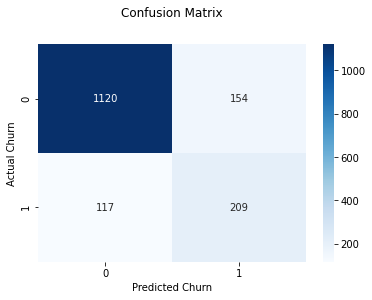

In [53]:
y_test_pred = model.predict(X_test_enc)

conf_matrix = confusion_matrix(y_test_enc, y_test_pred)
sns.heatmap(pd.DataFrame(conf_matrix), annot = True, cmap = 'Blues', fmt = 'g')
plt.title('Confusion Matrix', y = 1.1)
plt.ylabel('Actual Churn')
plt.xlabel('Predicted Churn')

Abbiamo 117 falsi negativi e 154 falsi positivi. Il modello sembra commettere in proporzione più errori sui positivi che non sui negativi, nonostante l'applicazione della tecnica *SMOTE* abbia bilanciato il dataset (anche se chiaramente non con esempi reali, bensì artificiali).

Per avere più informazioni, qui sotto mostro un report più completo sulle prestazioni del modello sul test set.

In [54]:
print(classification_report(y_test_enc, y_test_pred))

              precision    recall  f1-score   support

           0       0.91      0.88      0.89      1274
           1       0.58      0.64      0.61       326

    accuracy                           0.83      1600
   macro avg       0.74      0.76      0.75      1600
weighted avg       0.84      0.83      0.83      1600



Grazie all'applicazione della tecnica *SMOTE*, nonostante il dataset di partenza fosse sbilanciato il nostro modello non sbaglia eccessivamente nella classificazione dei positivi (anche se commette comunque diversi errori): se non avessimo applicato questa tecnica, magari avremmo avuto meno errori sugli esempi negativi (e magari anche un'accuracy di 2/3 punti percentuali più alta), ma avremmo commesso molti più errori sugli esempi positivi.
Bisogna infatti considerare che in un contesto come questo i falsi negativi sono molto più pericolosi dei falsi positivi: ad una banca costa probabilmente molto meno venire incontro ad un cliente che in realtà alla fine non se ne andrà (falso positivo) che non lasciarsi sfuggire un cliente perché credeva che intendesse rimanere (falso negativo).

Può essere interessante a questo punto analizzare i valori di importanza relativa delle varie feature, secondo quanto appreso dal modello.

In [55]:
feature_importances = model.named_steps['classifier'].feature_importances_
feature_importances

array([0.27362694, 0.15671839, 0.12941222, 0.14598996, 0.05422464,
       0.10607786, 0.05849619, 0.03170064, 0.04375315])

Visualizziamo ora tali valori con un grafico a barre.

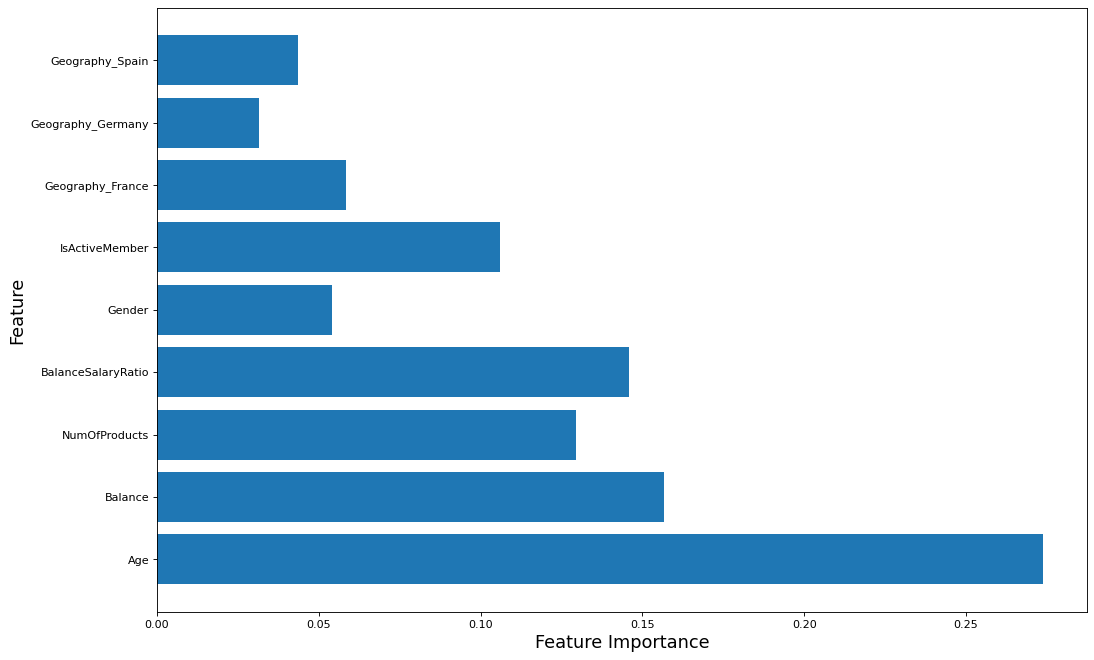

In [56]:
# Funzione che restituisce la lista delle feature in modo che il loro ordinamento sia coerente con quello
# dei corrispondenti valori di importanza relativa.
# Questo è necessario perché l'ordine delle feature cambia quando il dataset passa attraverso il preprocessore
# dei dati: le feature numeriche vengono infatti messe in testa e tutte le altre in coda (l'ordine delle
# feature numeriche e categoriche rimane comunque lo stesso).
def get_feature_names():
    return num_cols + [x for x in list(X_test_enc.columns) if x not in num_cols]


# Funzione per visualizzare i valori di importanza relativa delle feature, con un grafico a barre.
def plot_feature_importances(feature_importances):
    plt.figure(figsize = (15, 10), dpi = 80)
    plt.barh(get_feature_names(), feature_importances, align = 'center')
    plt.xlabel('Feature Importance', size = 16)
    plt.ylabel('Feature', size = 16)
    plt.show()

plot_feature_importances(feature_importances)

La magnitudine di questi valori è in linea di massima abbastanza in accordo con le analisi fatte in precedenza: le feature che hanno pesi più alti (in valore assoluto) sono tendenzialmente quelle che avevano ottenuto valori più alti di Mutua Informazione.